In [1]:
import pandas as pd
import ast

# Load dataset
df = pd.read_csv("Final_Processed_Dataset.csv")

# Convert string representation of lists to actual lists
df['parsed_list'] = df['parsed_list'].apply(ast.literal_eval)

# Create list of (word, tag) pairs per sentence
data = [
    [(token[0], token[1]) for token in row if isinstance(token, (list, tuple)) and len(token) >= 2]
    for row in df['parsed_list']
]

# Now separate words and tags
X = [[word for word, tag in sentence] for sentence in data]
y = [[tag for word, tag in sentence] for sentence in data]



In [2]:
# Word vocabulary
words = list(set(word for sentence in X for word in sentence))
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"] = 0
word2idx["UNK"] = 1
idx2word = {i: w for w, i in word2idx.items()}


In [3]:
valid_tags = {
    'B-HSK', 'I-HSK', 'B-JOB', 'I-JOB', 'B-YOE', 'I-YOE',
    'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-EDU', 'I-EDU', 'O'
}
from sklearn.preprocessing import LabelEncoder

# Filter out invalid tags
filtered_y = [
    [tag if tag in valid_tags else 'O' for tag in seq]
    for seq in y
]

# Flatten to fit LabelEncoder
all_tags_flat = [tag for seq in filtered_y for tag in seq]

tag_encoder = LabelEncoder()
tag_encoder.fit(all_tags_flat)

tag2idx = {'PAD': 0}
tag2idx.update({tag: i + 1 for i, tag in enumerate(valid_tags)})
idx2tag = {i: tag for tag, i in tag2idx.items()}



In [4]:
from sklearn.model_selection import train_test_split

# Step 1: Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Step 2: Split train+val into actual train and val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 900

# Word encoding
X_train_enc = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in X_train]
X_test_enc = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in X_test]

X_train_pad = pad_sequences(X_train_enc, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_enc, maxlen=max_len, padding='post')
# Define valid tags again
valid_tags = {
    'B-HSK', 'I-HSK', 'B-JOB', 'I-JOB', 'B-YOE', 'I-YOE',
    'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-EDU', 'I-EDU', 'O'
}

# Filter any tag not in valid_tags and replace it with 'O'
y_train = [[t if t in valid_tags else 'O' for t in seq] for seq in y_train]
y_test = [[t if t in valid_tags else 'O' for t in seq] for seq in y_test]

# Encode y with updated tag2idx
y_train_enc = [[tag2idx.get(t, tag2idx['O']) for t in s] for s in y_train]
y_test_enc = [[tag2idx.get(t, tag2idx['O']) for t in s] for s in y_test]

# Pad with 'PAD' tag index (which is now 0)
y_train_pad = pad_sequences(y_train_enc, maxlen=max_len, padding='post', value=tag2idx['PAD'])
y_test_pad = pad_sequences(y_test_enc, maxlen=max_len, padding='post', value=tag2idx['PAD'])


In [6]:
# Encode validation inputs
X_val_enc = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in X_val]

# Pad validation input
X_val_pad = pad_sequences(X_val_enc, maxlen=max_len, padding='post')

# Filter + encode validation targets
y_val = [[t if t in valid_tags else 'O' for t in seq] for seq in y_val]
y_val_enc = [[tag2idx.get(t, tag2idx['O']) for t in seq] for seq in y_val]
y_val_pad = pad_sequences(y_val_enc, maxlen=max_len, padding='post', value=tag2idx['PAD'])


In [7]:
print("Tag2Idx:", tag2idx)
print("Idx2Tag:", idx2tag)


Tag2Idx: {'PAD': 0, 'B-JOB': 1, 'B-LOC': 2, 'I-ORG': 3, 'B-YOE': 4, 'I-LOC': 5, 'B-HSK': 6, 'O': 7, 'I-YOE': 8, 'I-EDU': 9, 'B-EDU': 10, 'B-ORG': 11, 'I-HSK': 12, 'I-JOB': 13}
Idx2Tag: {0: 'PAD', 1: 'B-JOB', 2: 'B-LOC', 3: 'I-ORG', 4: 'B-YOE', 5: 'I-LOC', 6: 'B-HSK', 7: 'O', 8: 'I-YOE', 9: 'I-EDU', 10: 'B-EDU', 11: 'B-ORG', 12: 'I-HSK', 13: 'I-JOB'}


In [8]:
import numpy as np

embedding_dim = 100
embedding_index = {}

with open("glove.6B.100d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

embedding_matrix = np.zeros((len(word2idx), embedding_dim))
for word, i in word2idx.items():
    vec = embedding_index.get(word.lower())
    if vec is not None:
        embedding_matrix[i] = vec
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras.optimizers import Adam
import numpy as np

# --- Custom CRF Layer (updated for gradient tracking and masking support) ---
class CRF(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CRF, self).__init__(**kwargs)

    def build(self, input_shape):
        self.trans = self.add_weight(name="trans", 
                                     shape=(self.output_dim, self.output_dim), 
                                     initializer="uniform",
                                     trainable=True)
        super(CRF, self).build(input_shape)

    def call(self, logits):
        return logits  # Just return raw logits; decoding handled externally

    def loss_fn(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def accuracy_fn(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
        mask = tf.cast(tf.math.not_equal(y_true, 0), tf.float32)
        matches = tf.cast(tf.equal(y_true, y_pred), tf.float32)
        return tf.reduce_sum(matches * mask) / tf.reduce_sum(mask)

# --- Define Model Building Function ---
def build_bilstm_crf_model(vocab_size, tag_size, embedding_matrix, max_len=100, embedding_dim=100):
    input_layer = Input(shape=(max_len,))

    model = Embedding(input_dim=vocab_size,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=False)(input_layer)

    model = Bidirectional(LSTM(units=64, return_sequences=True))(model)
    logits = TimeDistributed(Dense(tag_size))(model)

    crf = CRF(tag_size)
    output = crf(logits)

    model = Model(inputs=input_layer, outputs=output)
    
    model.compile(optimizer=Adam(0.001), 
                  loss=crf.loss_fn, 
                  metrics=[crf.accuracy_fn])
    return model


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Set sequence length and embedding dim
max_len = 900
embedding_dim = 100

# Define the model
model = build_bilstm_crf_model(
    vocab_size=len(word2idx),
    tag_size=len(tag2idx),
    embedding_matrix=embedding_matrix,
    max_len=max_len,
    embedding_dim=embedding_dim
)

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3,
    restore_best_weights=True
)

model.fit(
    X_train_pad, y_train_pad,
    batch_size=32,
    epochs=20,
    validation_data=(X_val_pad, y_val_pad),
    callbacks=[early_stop]
)


Epoch 1/20
47/47 [==============================] - 23s 408ms/step - loss: 0.9405 - accuracy_fn: 0.7906 - val_loss: 0.6181 - val_accuracy_fn: 0.8377
Epoch 2/20
47/47 [==============================] - 18s 373ms/step - loss: 0.5615 - accuracy_fn: 0.8480 - val_loss: 0.5190 - val_accuracy_fn: 0.8587
Epoch 3/20
47/47 [==============================] - 20s 423ms/step - loss: 0.4772 - accuracy_fn: 0.8673 - val_loss: 0.4467 - val_accuracy_fn: 0.8699
Epoch 4/20
47/47 [==============================] - 21s 443ms/step - loss: 0.4114 - accuracy_fn: 0.8799 - val_loss: 0.3917 - val_accuracy_fn: 0.8794
Epoch 5/20
47/47 [==============================] - 22s 475ms/step - loss: 0.3664 - accuracy_fn: 0.8887 - val_loss: 0.3598 - val_accuracy_fn: 0.8880
Epoch 6/20
47/47 [==============================] - 21s 440ms/step - loss: 0.3367 - accuracy_fn: 0.8960 - val_loss: 0.3328 - val_accuracy_fn: 0.8949
Epoch 7/20
47/47 [==============================] - 19s 402ms/step - loss: 0.3158 - accuracy_fn: 0.9021 - 

In [11]:
# Save the full model (if compatible)
model.save("model.h5")


C:\Users\ABC\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Predict logits on the test set
y_pred_logits = model.predict(X_test_pad)
y_pred = y_pred_logits.argmax(axis=-1)

# Remove padding and convert indices to tags
y_true_seq = []
y_pred_seq = []

for true, pred in zip(y_test_pad, y_pred):
    true_tags = [idx2tag[idx] for idx in true if idx != tag2idx['PAD']]
    pred_tags = [idx2tag[idx] for idx in pred[:len(true_tags)]]  # match length to true sequence
    y_true_seq.append(true_tags)
    y_pred_seq.append(pred_tags)


10/10 [==============================] - 2s 144ms/step


In [13]:
def visualize_predictions(model, X_test, y_test, idx2word, idx2tag, num_samples=5):
    import tensorflow as tf
    y_pred_logits = model.predict(X_test)
    y_pred = tf.argmax(y_pred_logits, axis=-1)

    for i in range(num_samples):
        input_ids = X_test[i]
        true_labels = y_test[i]
        pred_labels = y_pred[i]

        print(f"\n🟦 Sample {i+1} — Token / True / Predicted:")
        for token_id, true, pred in zip(input_ids, true_labels, pred_labels):
            if token_id != 0:  # skip padding
                token = idx2word.get(int(token_id), "[UNK]")
                true_tag = idx2tag.get(int(true), "O")
                pred_tag = idx2tag.get(int(pred), "O")
                print(f"{token:15} | {true_tag:10} | {pred_tag}")


In [14]:

visualize_predictions(model, X_test_pad, y_test_pad, idx2word, idx2tag, num_samples=3)


10/10 [==============================] - 2s 165ms/step

🟦 Sample 1 — Token / True / Predicted:
about           | O          | O
us              | O          | O
one             | O          | O
team            | O          | O
.               | O          | O
global          | O          | O
challenges      | O          | O
.               | O          | O
infinite        | O          | O
opportunities   | O          | O
.               | O          | O
at              | O          | O
viasat          | B-ORG      | B-ORG
,               | O          | O
we              | O          | O
'               | O          | O
re              | O          | O
on              | O          | O
a               | O          | O
mission         | O          | O
to              | O          | O
deliver         | O          | O
connections     | O          | O
with            | O          | O
the             | O          | O
capacity        | O          | O
to              | O          | O
change    

In [15]:
import pickle
import numpy as np

# Save weights
model.save_weights("model_weights.h5")

# Save vocab and tag mappings
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)

with open("tag2idx.pkl", "wb") as f:
    pickle.dump(tag2idx, f)

# Save embedding matrix
np.save("embedding_matrix.npy", embedding_matrix)

 

In [16]:
def bio_to_spans(tags):
    """Convert BIO-tag sequence into spans of the form (start, end, label)."""
    spans = []
    start = None
    label = None
    for i, tag in enumerate(tags):
        if tag.startswith("B-"):
            if start is not None:
                spans.append((start, i - 1, label))
            start = i
            label = tag[2:]
        elif tag.startswith("I-") and start is not None and tag[2:] == label:
            continue
        else:
            if start is not None:
                spans.append((start, i - 1, label))
                start = None
                label = None
    if start is not None:
        spans.append((start, len(tags) - 1, label))
    return spans


In [17]:
def show_good_and_bad_examples(pred_seqs, true_seqs, token_seqs, num_tokens_context=3):
    good_found = False
    bad_found = False

    for tokens, preds, trues in zip(token_seqs, pred_seqs, true_seqs):
        pred_spans = set(bio_to_spans(preds))
        true_spans = set(bio_to_spans(trues))

        if pred_spans == true_spans and not good_found:
            for span in sorted(true_spans):
                start, end, label = span
                context_start = max(start - num_tokens_context, 0)
                context_end = min(end + num_tokens_context + 1, len(tokens))

                print("\n🟢 GOOD EXAMPLE (All Entities Correct in Context):")
                print("Context:           ", " ".join(tokens[context_start:context_end]))
                print("Predicted Labels:  ", preds[context_start:context_end])
                print("True Labels:       ", trues[context_start:context_end])
                good_found = True
                break

        missed = true_spans - pred_spans
        if missed and not bad_found:
            for span in sorted(missed):
                start, end, label = span
                context_start = max(start - num_tokens_context, 0)
                context_end = min(end + num_tokens_context + 1, len(tokens))

                print("\n🔴 BAD EXAMPLE (Missed Entity):")
                print("Context:           ", " ".join(tokens[context_start:context_end]))
                print("Predicted Labels:  ", preds[context_start:context_end])
                print("True Labels:       ", trues[context_start:context_end])
                bad_found = True
                break

        if good_found and bad_found:
            break


In [18]:
# Convert predictions to tag strings
y_pred_logits = model.predict(X_test_pad)
y_pred_seq = y_pred_logits.argmax(axis=-1)
y_true_seq = y_test_pad

# Convert index IDs to tag strings
y_pred_tags = [[idx2tag[idx] for idx in seq] for seq in y_pred_seq]
y_true_tags = [[idx2tag[idx] for idx in seq] for seq in y_true_seq]

# Reconstruct original tokens (you already have this earlier as `X_test`)
token_seqs = [[idx2word.get(idx, 'UNK') for idx in seq if idx != 0] for seq in X_test_pad]

# Call the function
show_good_and_bad_examples(y_pred_tags, y_true_tags, token_seqs)


10/10 [==============================] - 2s 177ms/step

🔴 BAD EXAMPLE (Missed Entity):
Context:            focused on providing airline employees as well as
Predicted Labels:   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
True Labels:        ['O', 'O', 'O', 'B-JOB', 'I-JOB', 'O', 'O', 'O']

🟢 GOOD EXAMPLE (All Entities Correct in Context):
Context:            on experience with snowflake . sound understanding
Predicted Labels:   ['O', 'O', 'O', 'B-HSK', 'O', 'O', 'O']
True Labels:        ['O', 'O', 'O', 'B-HSK', 'O', 'O', 'O']


In [19]:
from seqeval.metrics import classification_report, precision_score, recall_score, f1_score

# Sample format:
# y_true_seq = [['B-ORG', 'I-ORG', 'O'], ['B-LOC', 'O']]
# y_pred_seq = [['B-ORG', 'O', 'O'], ['B-LOC', 'O']]

def evaluate_with_seqeval(y_true_seq, y_pred_seq):
    print("\n📋 CoNLL-style Evaluation using seqeval:\n")

    print(classification_report(y_true_seq, y_pred_seq, digits=4))

    precision = precision_score(y_true_seq, y_pred_seq)
    recall = recall_score(y_true_seq, y_pred_seq)
    f1 = f1_score(y_true_seq, y_pred_seq)

    print(f"\n🔹 Precision: {precision:.4f}")
    print(f"🔹 Recall:    {recall:.4f}")
    print(f"🔹 F1 Score:  {f1:.4f}")

    return precision, recall, f1


In [20]:
y_true_tags = [[idx2tag.get(idx, "O") for idx in seq] for seq in y_test_pad]
y_pred_tags = [[idx2tag.get(idx, "O") for idx in seq] for seq in y_pred_seq]


In [21]:
def clean_tags(tags):
    valid = {'B-HSK', 'I-HSK', 'B-JOB', 'I-JOB', 'B-YOE', 'I-YOE',
             'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-EDU', 'I-EDU', 'O'}
    return [[tag if tag in valid else 'O' for tag in seq] for seq in tags]

y_true_tags = clean_tags(y_true_tags)
y_pred_tags = clean_tags(y_pred_tags)


In [22]:
# Assume these are already your decoded predictions:
# y_true_seq = [['B-ORG', 'I-ORG', 'O'], ...]
# y_pred_seq = [['B-ORG', 'O', 'O'], ...]

evaluate_with_seqeval(y_true_tags, y_pred_tags)



📋 CoNLL-style Evaluation using seqeval:

              precision    recall  f1-score   support

         EDU     0.4811    0.3815    0.4255       367
         HSK     0.5859    0.5551    0.5701      8816
         JOB     0.4456    0.3958    0.4192       662
         LOC     0.8069    0.6518    0.7211       718
         ORG     0.5827    0.3716    0.4538      1375
         YOE     0.7327    0.7064    0.7193       419

   micro avg     0.5924    0.5318    0.5604     12357
   macro avg     0.6058    0.5104    0.5515     12357
weighted avg     0.5927    0.5318    0.5586     12357


🔹 Precision: 0.5924
🔹 Recall:    0.5318
🔹 F1 Score:  0.5604


(0.592355539529433, 0.531763372986971, 0.5604264392324094)

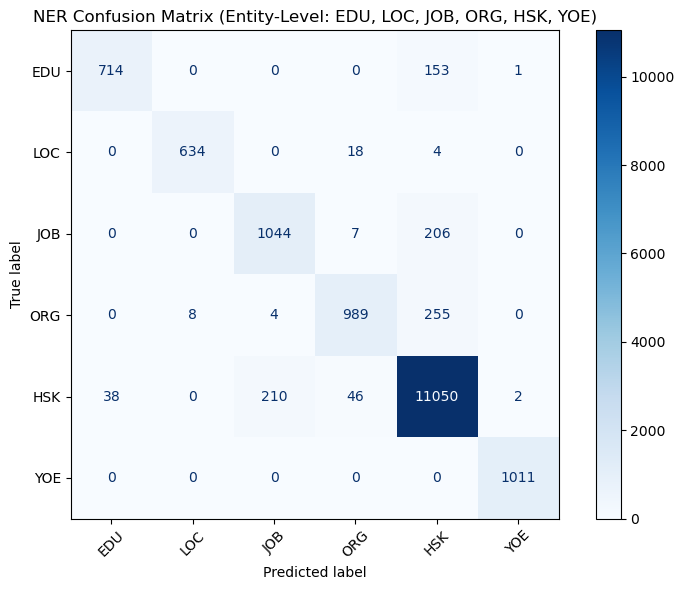

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If your y_true_seq and y_pred_seq are already tag strings, use them directly
# Example: [['B-ORG', 'I-ORG', 'O'], ['B-LOC', 'O']]

# --- Step 1: Flatten sequences and strip BIO prefixes ---
def flatten_and_merge_tags(y_true_seq, y_pred_seq):
    y_true_flat, y_pred_flat = [], []
    for y_true, y_pred in zip(y_true_seq, y_pred_seq):
        for true_tag, pred_tag in zip(y_true, y_pred):
            y_true_flat.append(true_tag.split('-')[-1] if true_tag != 'O' else 'O')
            y_pred_flat.append(pred_tag.split('-')[-1] if pred_tag != 'O' else 'O')
    return y_true_flat, y_pred_flat

y_true_flat, y_pred_flat = flatten_and_merge_tags(y_true_tags, y_pred_tags)

# --- Step 2: Define target entity labels ---
labels = ['EDU', 'LOC', 'JOB', 'ORG', 'HSK', 'YOE']

# --- Step 3: Filter only the tags of interest (ignore 'O') ---
filtered_true = [t for t, p in zip(y_true_flat, y_pred_flat) if t in labels]
filtered_pred = [p for t, p in zip(y_true_flat, y_pred_flat) if t in labels]

# --- Step 4: Compute and display confusion matrix ---
cm = confusion_matrix(filtered_true, filtered_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(include_values=True, cmap='Blues', xticks_rotation=45, ax=ax, values_format='.0f')
plt.title("NER Confusion Matrix (Entity-Level: EDU, LOC, JOB, ORG, HSK, YOE)")
plt.tight_layout()
plt.show()
